# Classification of Faces

In this excercise, we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". The data is from a random sample of 8 persons of the OXFORD VGG Face dataset, more information here: http://www.robots.ox.ac.uk/~vgg/data/vgg_face/.

## Downloading of Data

You can download the data using the following code:

In [42]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

In [43]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve("https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1","8_faces_train_and_valid.hdf5")

In [44]:
import h5py
h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(h5f_X.keys())

print(h5f_X["X_train_8_faces"])

X_train = h5f_X['X_train_8_faces'][:]
print(X_train.shape)
print(X_train[0][0])
Y_train = h5f_X['Y_train_8_faces'][:]
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces'][:]
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces'][:]
print(Y_valid.shape, X_valid.dtype)

<KeysViewHDF5 ['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']>
<HDF5 dataset "X_train_8_faces": shape (2000, 48, 48, 3), type "<f8">
(2000, 48, 48, 3)
[[14. 17. 42.]
 [14. 17. 41.]
 [13. 18. 42.]
 [14. 18. 41.]
 [14. 18. 40.]
 [13. 17. 41.]
 [14. 17. 39.]
 [14. 17. 40.]
 [13. 17. 39.]
 [13. 17. 39.]
 [13. 17. 39.]
 [14. 16. 39.]
 [13. 16. 38.]
 [12. 15. 35.]
 [12. 15. 35.]
 [12. 15. 36.]
 [12. 15. 36.]
 [12. 15. 35.]
 [12. 15. 35.]
 [12. 15. 35.]
 [13. 15. 35.]
 [13. 15. 34.]
 [13. 15. 34.]
 [12. 15. 34.]
 [12. 14. 34.]
 [12. 15. 33.]
 [11. 15. 34.]
 [12. 14. 33.]
 [11. 14. 32.]
 [12. 14. 34.]
 [12. 14. 35.]
 [12. 14. 37.]
 [13. 15. 41.]
 [13. 15. 46.]
 [13. 15. 49.]
 [13. 15. 51.]
 [13. 16. 52.]
 [13. 16. 52.]
 [14. 16. 52.]
 [14. 17. 53.]
 [16. 18. 54.]
 [18. 19. 55.]
 [17. 19. 54.]
 [17. 19. 53.]
 [17. 19. 53.]
 [17. 19. 51.]
 [17. 18. 51.]
 [16. 18. 50.]]
(2000,)
(400, 48, 48, 3)
(400,) float64


250


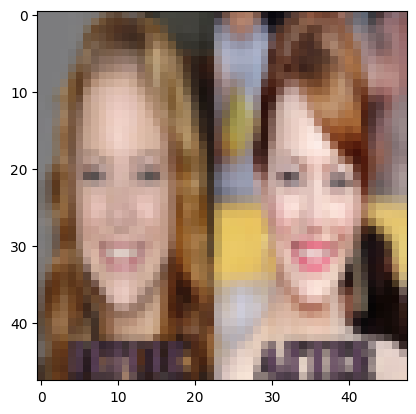

In [45]:
n = 0 #Miranda Cosgrove
n = 1 #Chris Martin (singer)
n = 2 #Emma Stone (actress)
n = 3 #Jamie Foxx (actor)
n = 4 #Steve Jobs (entrepreneur)
n = 5 #Zac Efron (actor)
n = 6 #Sandra Oh (actress)
n = 7 #Taryn Manning (actress)
n = 2
idx=np.reshape(np.where(Y_train[0:len(Y_train)]==n),(250))
print(len(Y_train[idx]))
plt.imshow(np.asarray(X_train[idx][0],dtype="uint8"))

In [46]:
#Downloading the data, if it does not exist
if not os.path.isfile('8_faces_test.hdf5'):
  urllib.request.urlretrieve("https://www.dropbox.com/s/ugxrdo0lpc2ixvr/8_faces_test.hdf5?dl=1","8_faces_test.hdf5")
h5f_X = h5py.File('8_faces_test.hdf5', 'r')
print(list(h5f_X.keys()))
X_test = h5f_X['X_test_8_faces'][:]
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces'][:]
print(Y_test.shape)

['X_test_8_faces', 'Y_test_8_faces']
(400, 48, 48, 3)
(400,)


In [47]:
np.min(X_train),np.max(X_train),np.min(X_test),np.max(X_test)
X_train /= 255
X_valid /= 255
X_test /= 255

## a) Training an CNN from scratch

Train a model (as shown below) from scratch, using the training data for training and the validation data for validation. For all activations in the hidden layer use the 'ReLU', for the last layer use softmax. Use 3x3 convolutions and use padding = same.

* Plot the learning curves: (epochs vs training loss and validation loss) and epochs vs accuracy. 
* Calculate the accuracy on the test set (you should reach an accuracy of about 0.54)
* Calculate the confusion matrix
* Have a look at missclassified examples

Image of the network:
https://github.com/ioskn/mldl_htwg/blob/master/uebungen/dl_cnn_faces_net.png

In [48]:
# Define our new model
model = Sequential()
model.add(Conv2D(15, (3, 3), input_shape=(48, 48, 3), name='conv2d_4', padding="same", activation="relu"))
model.add(Conv2D(15, (3, 3), input_shape=(48, 48, 3), name='conv2d_5', padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_2', padding="same"))
model.add(Conv2D(30, (3, 3), input_shape=(24, 24, 3), name='conv2d_6', padding="same", activation="relu"))
model.add(Conv2D(30, (3, 3), input_shape=(24, 24, 3), name='conv2d_7', padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_3', padding="same"))
model.add(Flatten(name='flatten_2'))
model.add(Dense(300, activation='relu', name='dense_2'))
model.add(Dropout(0.2, name="dropout"))
model.add(Dense(8, activation='softmax', name='dense_3'))

# Compile it
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train it
history = model.fit(X_train, X_train, epochs=10, validation_data=(Y_valid, Y_valid))


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "c:\Program Files\Python38\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Program Files\Python38\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Program Files\Python38\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\Program Files\Python38\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\Program Files\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue
      await self.process_one()
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 518, in process_one
      await dispatch(*args)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell
      await result
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 766, in execute_request
      reply_content = await reply_content
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Z0010961\AppData\Local\Temp\ipykernel_21920\2106220063.py", line 21, in <module>
      history = model.fit(X_train, X_train, epochs=10, validation_data=(Y_valid, Y_valid))
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py", line 1085, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py", line 1179, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\metrics\base_metric.py", line 723, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\metrics\accuracy_metrics.py", line 426, in categorical_accuracy
      return metrics_utils.sparse_categorical_matches(
    File "C:\Users\Z0010961\AppData\Roaming\Python\Python38\site-packages\keras\src\utils\metrics_utils.py", line 968, in sparse_categorical_matches
      matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal'
Incompatible shapes: [32,48,48] vs. [32]
	 [[{{node Equal}}]] [Op:__inference_train_function_6269]

## b) Training using transfer learning
In transfer learning you use an existing trained model with given weights trained on a different task. You then add a few layers yourself and only train them. The model you add should look like:

```
my_dense1 (Dense)            (None, 512)               262656    
_________________________________________________________________
my_dense2 (Dense)            (None, 512)               262656    
_________________________________________________________________
my_dense3 (Dense)            (None, 100)               51300     
_________________________________________________________________
my_dense4 (Dense)            (None, 8)                 808       
```

Use the following code as a starting point:

In [ ]:
from keras.applications import VGG16
img_height = img_width = 48
base_model = VGG16(weights='imagenet', include_top=False,input_shape = (img_width, img_height, 3))

58889256/58889256 [==============================] - 12s 0us/step


In [ ]:
fc1 = base_model.output
fc1 = Flatten()(fc1)
#...
#Your code here
#...
fc1 = Dense(8,activation='softmax', name='my_dense4')(fc1)
model_trans = tf.compat.v1.keras.Model(base_model.input, fc1) #Current hack for TF 2.0 and keras
model_trans.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
#base_model.summary()
for layer in model_trans.layers:
  name = layer.name
  if name.startswith('my'):
    layer.trainable = True
    print(name)
  else:
    layer.trainable = False

my_dense4


Do the same analysis as in a) above. You should get an accuracy of approx 0.61

## c) Try to get better.

Ideas: use dropout and other tricks to prevent overfitting. Try to learn some convulutional layers as well.